# ETF Trading Strategy with Moving Averages and Signal Optimization

## Introduction
In this notebook, we develop and backtest a trading strategy for an Exchange-Traded Fund (ETF) using moving averages to generate buy and sell signals. The strategy involves optimizing the short and long moving average windows through a grid search to maximize performance, measured by the Sharpe Ratio.

## Steps Overview

1. **Imports and Configuration**
   - Import necessary libraries, including Pandas, yfinance, and other machine learning and data processing tools.
   - Set up the FRED API key to access economic data.

2. **Data Download and Preparation**
   - Define the date range for the data.
   - Download historical price data for the ETF using `yfinance`.
   - Fetch relevant economic indicators, such as the Effective Federal Funds Rate (EFFR) from the Federal Reserve Economic Data (FRED).
   - Adjust and clean the data to ensure alignment for analysis.

3. **Calculating Returns and Excess Returns**
   - Calculate daily returns of the ETF.
   - Compute excess returns by subtracting the adjusted risk-free rate (EFFR) from the daily returns.

4. **Data Splitting and Grid Search for Strategy Optimization**
   - Split the dataset into training and testing sets to evaluate the strategy.
   - Define a range of short and long moving average windows.
   - Calculate moving averages and detect crossovers to generate buy/sell signals.
   - Calculate strategy returns and evaluate using the Sharpe Ratio.
   - Identify the best-performing short and long window combination.

5. **Backtesting the Optimized Strategy**
   - Use the best parameters from the grid search to generate trading signals on the entire dataset.
   - Simulate the strategy by calculating positions, portfolio evolution, and PnL (Profit and Loss) over time.

6. **Performance Metrics Calculation and Visualization**
   - Calculate key performance metrics, including the Sharpe Ratio, Sortino Ratio, Maximum Drawdown, and Calmar Ratio for the test data.
   - Compute rolling metrics to assess the strategy's stability over time.
   
   **Visualizations**
   - Plot the evolution of portfolio value (`V_t`) over time.
   - Display strategy positions, dynamic bounds, and turnover metrics.
   - Visualize rolling performance metrics, such as the Rolling Sharpe Ratio, to compare the training and test data.



---

## Detailed Sections

### 1. Imports and Configuration
We begin by importing all necessary libraries and configuring the environment to access financial and economic data. This includes setting up the FRED API for obtaining the Effective Federal Funds Rate (EFFR).

### 2. Data Download and Preparation
The historical price data for the ETF is downloaded using `yfinance`, and the EFFR data is fetched from FRED. We then adjust the EFFR to daily rates and clean the data to remove any missing values.

### 3. Calculating Returns and Excess Returns
We calculate the daily returns of the ETF and adjust them for the risk-free rate to obtain the excess returns.

### 4. Data Splitting and Grid Search for Strategy Optimization
The data is split into training and testing sets, with the training data used for optimizing the strategy parameters and the test data reserved for evaluating the strategy's performance.

We conduct a grid search over a range of short and long moving average windows to find the best-performing combination based on the Sharpe Ratio. The strategy generates buy and sell signals based on crossovers between the short and long moving averages.

### 5. Backtesting the Optimized Strategy
Using the optimal moving average periods identified from the grid search, we backtest the strategy on the full dataset. Positions are calculated based on the signals, and the portfolio value (`V_t`) is updated over time to assess the strategy's effectiveness.

### 6. Performance Metrics Calculation and Visualization
We evaluate the strategy using several key performance metrics:
   - **Sharpe Ratio (Annualized):** Measures the risk-adjusted return of the strategy.
   - **Sortino Ratio (Annualized):** Adjusts the Sharpe Ratio by considering only downside risk.
   - **Maximum Drawdown:** Identifies the largest peak-to-trough decline in portfolio value.
   - **Calmar Ratio (Annualized):** Evaluates performance relative to the maximum drawdown.

Various plots are generated to illustrate the evolution of the portfolio value, strategy positions, and other performance indicators:
   - **Portfolio Value (`V_t`) Evolution:** Shows how the portfolio value changes over time.
   - **Strategy Positions and Dynamic Bounds:** Highlights the strategy’s trading positions and leverage constraints.
   - **Turnover and Volatility:** Displays turnover metrics and the volatility of the ETF's returns.
   - **Rolling Sharpe Ratio:** Visualizes the Sharpe Ratio over time for both the training and testing datasets.




### 1. Imports and Configuration

In [51]:
import pandas as pd
import yfinance as yf
import datetime
from fredapi import Fred
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from hyperopt import hp
from sklearn.model_selection import train_test_split
from hyperopt import STATUS_OK
from tensorflow.keras.optimizers import Adam
from hyperopt import fmin, tpe, Trials
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

### 2. Data Download and Preparation

In [52]:
# Set your FRED API key in the environment (this line is correct)
os.environ['FRED_API_KEY'] = '7cd90f6c84b53379f448cd4a6552c7ef'

# Initialize the Fred object
fred = Fred()

# Define start and end dates
start_date = datetime.datetime(2014, 1, 1) 
end_date = datetime.datetime(2019, 12, 31)

# Download SPTL data using yfinance
sptl_data = yf.download('SPTL', start=start_date, end=end_date)

# Fetch the EFFR data
effr_data = fred.get_series('EFFR', observation_start=start_date, observation_end=end_date)

# Convert EFFR data to a DataFrame and adjust for daily
effr_data_df = pd.DataFrame(effr_data, columns=['EFFR'])
dc = 1/252
effr_data_df['EFFR_Adjusted'] = effr_data_df['EFFR'] * dc

# Removing NAN values
effr_data_df = effr_data_df.dropna(inplace=False)
sptl_data = sptl_data.dropna(inplace=False)

# Check the first few rows of each DataFrame
print(effr_data_df.tail())
sptl_data.head()

[*********************100%%**********************]  1 of 1 completed

            EFFR  EFFR_Adjusted
2019-12-24  1.55       0.006151
2019-12-26  1.55       0.006151
2019-12-27  1.55       0.006151
2019-12-30  1.55       0.006151
2019-12-31  1.55       0.006151


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,29.924999,30.070000,29.924999,30.055,23.299049,25400
2014-01-03,29.959999,30.105000,29.959999,30.035,23.283543,22000
2014-01-06,30.110001,30.270000,30.110001,30.160,23.380453,3200
2014-01-07,30.240000,30.260000,30.200001,30.260,23.457960,3800
2014-01-08,30.075001,30.184999,30.075001,30.150,23.372688,14800


### 3. Calculating Returns and Excess Returns

In [53]:
# Calculating the return per unit of SPTL
sptl_data['Return'] = sptl_data['Close'].pct_change()

# Calculatin Excess Return
sptl_data['Excess_Return'] = sptl_data['Return'] - effr_data_df['EFFR_Adjusted'].reindex(sptl_data.index).fillna(method='ffill')

sptl_data.head()

/var/folders/tv/bjxgwfxn7578_3m4cl8608dm0000gn/T/ipykernel_26634/2675490396.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sptl_data['Excess_Return'] = sptl_data['Return'] - effr_data_df['EFFR_Adjusted'].reindex(sptl_data.index).fillna(method='ffill')


,Open,High,Low,Close,Adj Close,Volume,Return,Excess_Return
Date,,,,,,,,
2014-01-02,29.924999,30.070000,29.924999,30.055,23.299049,25400,NaN,NaN
2014-01-03,29.959999,30.105000,29.959999,30.035,23.283543,22000,-0.000665,-0.000983
2014-01-06,30.110001,30.270000,30.110001,30.160,23.380453,3200,0.004162,0.003844
2014-01-07,30.240000,30.260000,30.200001,30.260,23.457960,3800,0.003316,0.003038
2014-01-08,30.075001,30.184999,30.075001,30.150,23.372688,14800,-0.003635,-0.003913


### 4. Data Splitting and Grid Search for Strategy Optimization

In [54]:
# Split the dataset into training and testing sets
train_size = int(len(sptl_data) * 0.7)
train_data = sptl_data.iloc[:train_size].copy()
test_data = sptl_data.iloc[train_size:].copy()

# Define the range of short and long moving averages to test
short_windows = [5, 10, 15, 20]
long_windows = [10, 15, 20, 25]

grid_search_results_list = []

for short_window in short_windows:
    for long_window in long_windows:
        if short_window >= long_window:
            continue  # Ensures SMA period is shorter than LMA period
        
        # Calculate moving averages
        train_data['SMA'] = train_data['Close'].rolling(window=short_window, min_periods=1).mean()
        train_data['LMA'] = train_data['Close'].rolling(window=long_window, min_periods=1).mean()

        # Detect crossovers
        # Buy signal (1) when SMA crosses above LMA, Sell signal (-1) when SMA crosses below LMA
        train_data['Signal'] = 0  # Default signal
        train_data['Prev_SMA'] = train_data['SMA'].shift(1)
        train_data['Prev_LMA'] = train_data['LMA'].shift(1)
        train_data['Signal'] = np.where((train_data['SMA'] > train_data['LMA']) & (train_data['Prev_SMA'] <= train_data['Prev_LMA']), 1, train_data['Signal'])
        train_data['Signal'] = np.where((train_data['SMA'] < train_data['LMA']) & (train_data['Prev_SMA'] >= train_data['Prev_LMA']), -1, train_data['Signal'])

        # Calculate daily returns
        train_data['Daily_Return'] = train_data['Close'].pct_change() - effr_data_df['EFFR_Adjusted'].reindex(train_data.index).fillna(method='ffill')
        # Calculate strategy returns
        train_data['Strategy_Return'] = train_data['Signal'].shift(1) * train_data['Daily_Return']

        # Calculate Sharpe Ratio
        sharpe_ratio = train_data['Strategy_Return'].mean() / train_data['Strategy_Return'].std() * np.sqrt(252)

        # Append results
        grid_search_results_list.append({
            'Short_Window': short_window,
            'Long_Window': long_window,
            'Sharpe_Ratio': sharpe_ratio
        })

        # Clean up temporary columns to avoid affecting future iterations
        train_data.drop(['Prev_SMA', 'Prev_LMA', 'SMA', 'LMA', 'Signal', 'Daily_Return', 'Strategy_Return'], axis=1, inplace=True)

grid_search_results = pd.DataFrame(grid_search_results_list)
# Find the best parameters based on Sharpe Ratio
best_parameters = grid_search_results.loc[grid_search_results['Sharpe_Ratio'].idxmax()]

print(f'Best Parameters:\n{best_parameters}')

Best Parameters:
Short_Window    20.000000
Long_Window     25.000000
Sharpe_Ratio     0.208975
Name: 9, dtype: float64


/var/folders/tv/bjxgwfxn7578_3m4cl8608dm0000gn/T/ipykernel_26634/1964555264.py:30: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_data['Daily_Return'] = train_data['Close'].pct_change() - effr_data_df['EFFR_Adjusted'].reindex(train_data.index).fillna(method='ffill')
/var/folders/tv/bjxgwfxn7578_3m4cl8608dm0000gn/T/ipykernel_26634/1964555264.py:30: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_data['Daily_Return'] = train_data['Close'].pct_change() - effr_data_df['EFFR_Adjusted'].reindex(train_data.index).fillna(method='ffill')
/var/folders/tv/bjxgwfxn7578_3m4cl8608dm0000gn/T/ipykernel_26634/1964555264.py:30: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_data['Daily_Return'] = train_data['Close'].pct_change(

In [55]:
best_parameters

Short_Window    20.000000
Long_Window     25.000000
Sharpe_Ratio     0.208975
Name: 9, dtype: float64

### 5. Backtesting the Optimized Strategy

In [56]:
# Creating Signals 
# Placeholder values for the optimal window sizes
optimal_short_window = int(best_parameters['Short_Window'])
optimal_long_window = int(best_parameters['Long_Window'])

# Calculate the moving averages for the entire dataset
sptl_data['SMA'] = sptl_data['Close'].rolling(window=optimal_short_window, min_periods=1).mean()
sptl_data['LMA'] = sptl_data['Close'].rolling(window=optimal_long_window, min_periods=1).mean()

# Generate signals based on the moving averages
sptl_data['Signals'] = 0  # Default signal
sptl_data['Prev_SMA'] = sptl_data['SMA'].shift(1)
sptl_data['Prev_LMA'] = sptl_data['LMA'].shift(1)
sptl_data['Signals'] = np.where((sptl_data['SMA'] > sptl_data['LMA']) & (sptl_data['Prev_SMA'] <= sptl_data['Prev_LMA']), 1, sptl_data['Signals'])
sptl_data['Signals'] = np.where((sptl_data['SMA'] < sptl_data['LMA']) & (sptl_data['Prev_SMA'] >= sptl_data['Prev_LMA']), -1, sptl_data['Signals'])


# Display the head of the dataframe to verify the new column
sptl_data[['Close', 'SMA', 'LMA', 'Signals']].tail()


,Close,SMA,LMA,Signals
Date,,,,
2019-12-23,39.160000,39.8245,39.8708,0
2019-12-24,39.290001,39.7755,39.8564,0
2019-12-26,39.389999,39.7200,39.8340,0
2019-12-27,39.419998,39.6725,39.7948,0
2019-12-30,39.310001,39.6240,39.7616,0


In [57]:
# Initial capital
V0 = 200000.00

# Leverage
L = 10

# Maximum dollar value of SPTL that can be held, given the leverage
max_dollar_value = V0 * L

# Position storage
positions = [0]
dVt = []
max_value = [0]

# Reindex the EFFR data to align with sptl_data
sptl_data['EFFR_Adjusted'] = effr_data_df['EFFR_Adjusted'].reindex(sptl_data.index).fillna(method='ffill')

# Separate the training and test data
sptl_test_data = sptl_data.iloc[train_size:].copy()

# Initialize a list to store the evolution of V0 over time
Vt_evolution = [V0]

# Calculate the daily returns for SPTL
sptl_test_data['Pct_Change'] = sptl_test_data['Close'].pct_change()
pnl = 0

# Simulate the trading strategy on the test data
for index, row in sptl_test_data.iterrows():
    # Calculate the position based on the signal
    # Handle the first iteration where there is no previous signal
    if index == sptl_test_data.index[0]:
        position = 0  # No position on the first day
    else:
        previous_signal = sptl_test_data.loc[sptl_test_data.index < index, 'Signals'].iloc[-1]
        max_value.append(max_dollar_value / L)
        position = previous_signal * (round((max_dollar_value / row['Close']), 0) * row['Close'])
        positions.append(position)  # Store the position for the row
    
    
    # Calculate PnL for the row
        pnl = (row['Pct_Change'] - row['EFFR_Adjusted']) * position
        V0 += pnl  # Update V0 with the PnL
        Vt_evolution.append(V0)  # Append the new V0 to the evolution list
    # Update the maximum dollar value based on the new V0
    max_dollar_value = min(200000 * L, V0 * L)

    dVt.append(pnl) # Store the PnL for the row
sptl_test_data['Position'] = positions  # Store the positions in the DataFrame
sptl_test_data['Vt'] = max_value
sptl_test_data['dVt'] = dVt
# Print the evolution of V0 over time
for i, value in enumerate(Vt_evolution):
    print(f"Day {i}: V0 = {value:.2f}")

print(positions)


Day 0: V0 = 200000.00
Day 1: V0 = 200000.00
Day 2: V0 = 181722.58
Day 3: V0 = 181722.58
Day 4: V0 = 181722.58
Day 5: V0 = 181722.58
Day 6: V0 = 181722.58
Day 7: V0 = 181722.58
Day 8: V0 = 181722.58
Day 9: V0 = 181722.58
Day 10: V0 = 181722.58
Day 11: V0 = 181722.58
Day 12: V0 = 181722.58
Day 13: V0 = 181722.58
Day 14: V0 = 181722.58
Day 15: V0 = 181722.58
Day 16: V0 = 181722.58
Day 17: V0 = 181722.58
Day 18: V0 = 181722.58
Day 19: V0 = 181722.58
Day 20: V0 = 181722.58
Day 21: V0 = 181722.58
Day 22: V0 = 181722.58
Day 23: V0 = 181722.58
Day 24: V0 = 181722.58
Day 25: V0 = 181722.58
Day 26: V0 = 181722.58
Day 27: V0 = 181722.58
Day 28: V0 = 181722.58
Day 29: V0 = 181722.58
Day 30: V0 = 181722.58
Day 31: V0 = 180073.02
Day 32: V0 = 180073.02
Day 33: V0 = 180073.02
Day 34: V0 = 180073.02
Day 35: V0 = 180073.02
Day 36: V0 = 180073.02
Day 37: V0 = 180073.02
Day 38: V0 = 180073.02
Day 39: V0 = 180073.02
Day 40: V0 = 180073.02
Day 41: V0 = 180073.02
Day 42: V0 = 180073.02
Day 43: V0 = 180073.0

/var/folders/tv/bjxgwfxn7578_3m4cl8608dm0000gn/T/ipykernel_26634/2753923086.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sptl_data['EFFR_Adjusted'] = effr_data_df['EFFR_Adjusted'].reindex(sptl_data.index).fillna(method='ffill')


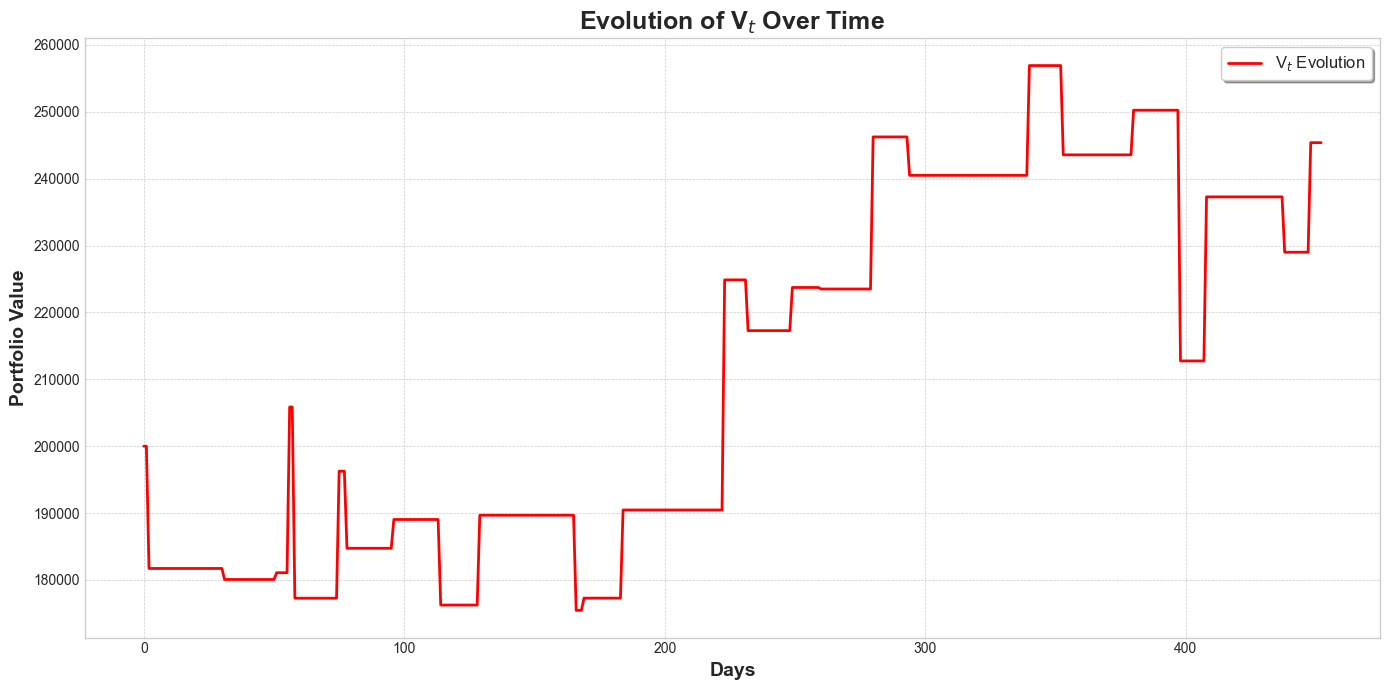

In [58]:
# Apply the Seaborn style for a nicer look
plt.style.use('seaborn-v0_8-whitegrid')

# Plot the evolution of V0 over time
plt.figure(figsize=(14, 7))
plt.plot(Vt_evolution, label='V$_t$ Evolution', color='red', linewidth=2)

# Set titles and labels with adjusted font sizes and weights
plt.title('Evolution of V$_t$ Over Time', fontsize=18, fontweight='bold')
plt.xlabel('Days', fontsize=14, fontweight='bold')
plt.ylabel('Portfolio Value', fontsize=14, fontweight='bold')

# Adjust legend appearance
plt.legend(fontsize=12, frameon=True, shadow=True)

# Ensure the grid is enabled for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust layout for better spacing and save the figure if needed
plt.tight_layout()

# Display the plot
plt.show()

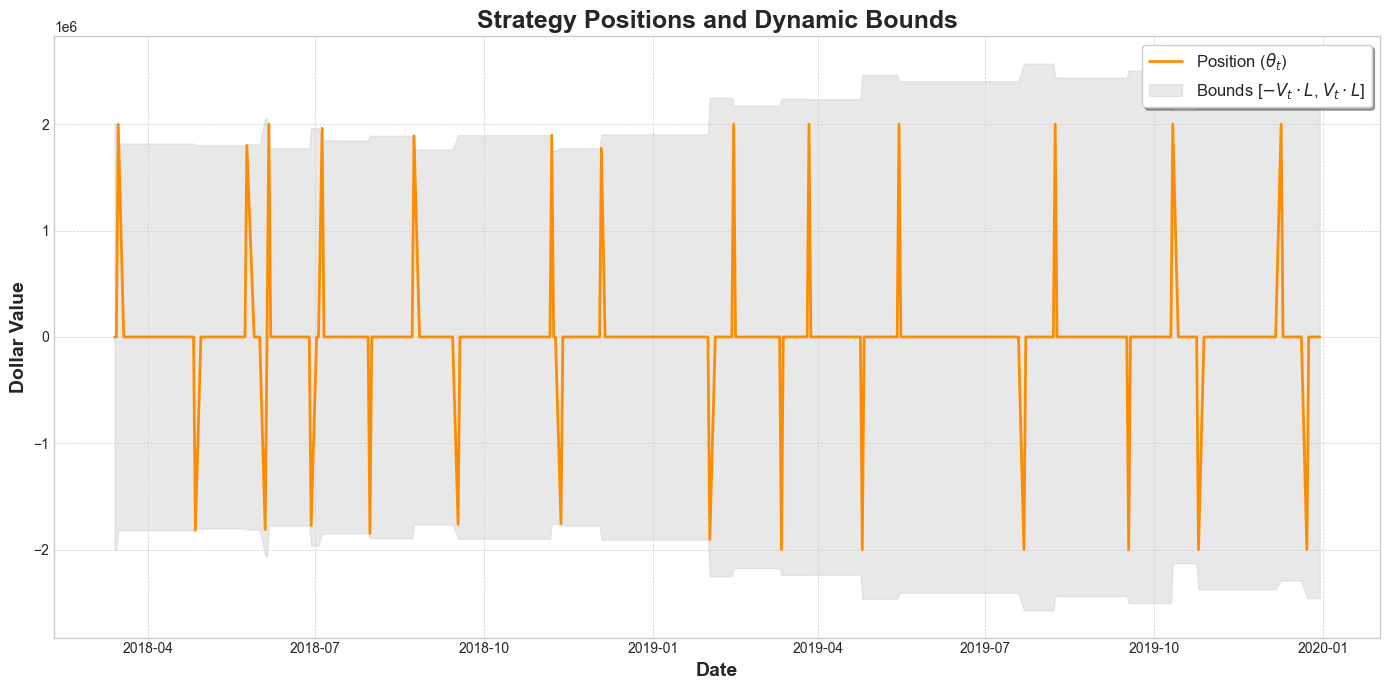

In [59]:
# PLOT THE POSITION OVER TIME AND THE DYNAMIC UPPER AND LOWER BOUNDS
# Add the positions list to sptl_test_data for plotting
sptl_test_data['Position'] = positions

# Calculate and add upper and lower bounds based on V0_evolution
sptl_test_data['Upper_Bound'] = [v0 * L for v0 in Vt_evolution]
sptl_test_data['Lower_Bound'] = [-v0 * L for v0 in Vt_evolution]

# Apply the Seaborn style for a nicer look
plt.style.use('seaborn-v0_8-whitegrid')

# Plotting
plt.figure(figsize=(14, 7))

# Plot positions over time
plt.plot(sptl_test_data.index, sptl_test_data['Position'], label='Position ($\\theta_t$)', color='darkorange', linewidth=2)

# Plot dynamic upper and lower bounds with a fill
plt.fill_between(sptl_test_data.index, sptl_test_data['Lower_Bound'], sptl_test_data['Upper_Bound'], color='lightgray', alpha=0.5, label='Bounds [$-V_t \\cdot L$, $V_t \\cdot L$]')

# Set titles and labels with adjusted font sizes and weights
plt.title('Strategy Positions and Dynamic Bounds', fontsize=18, fontweight='bold')
plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('Dollar Value', fontsize=14, fontweight='bold')

# Adjust legend appearance
plt.legend(fontsize=12, frameon=True, shadow=True)

# Ensure the grid is enabled for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust layout for better spacing and save the figure if needed
plt.tight_layout()

# Display the plot
plt.show()

Total Turnover: $99987100.30
Total Unit Turnover: 2784556.00


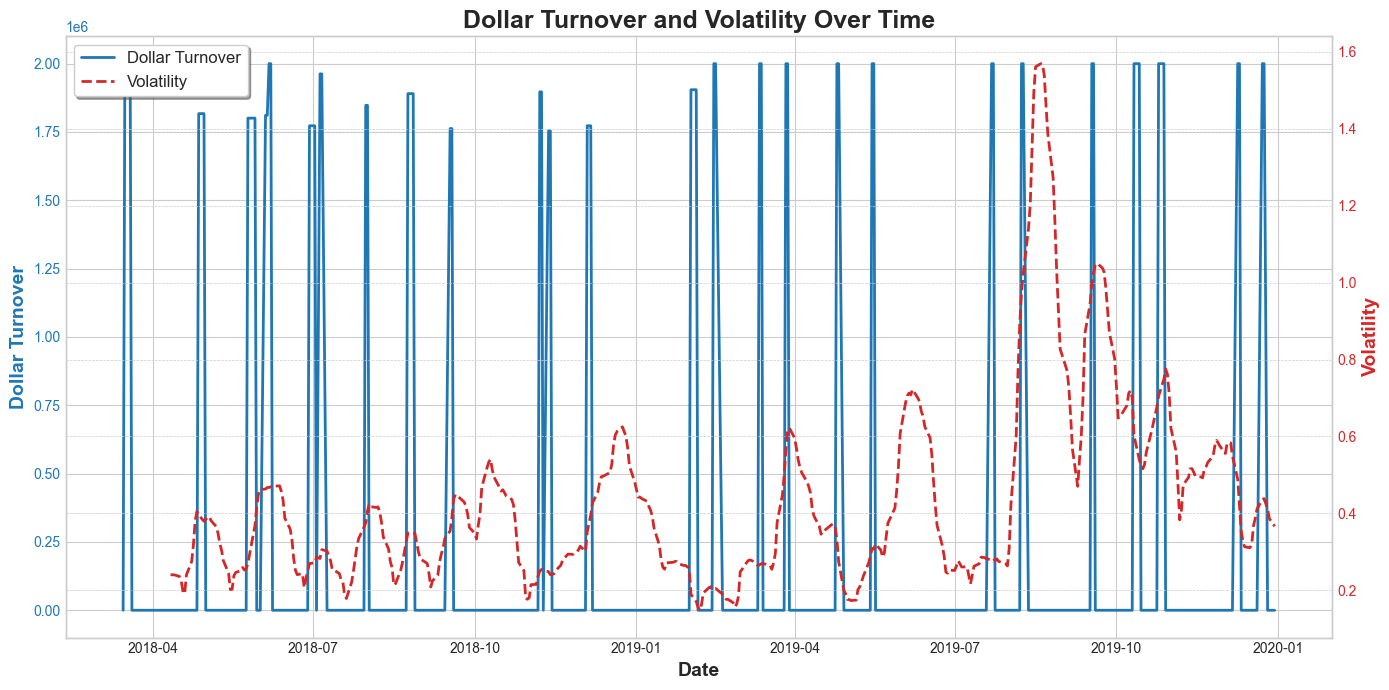

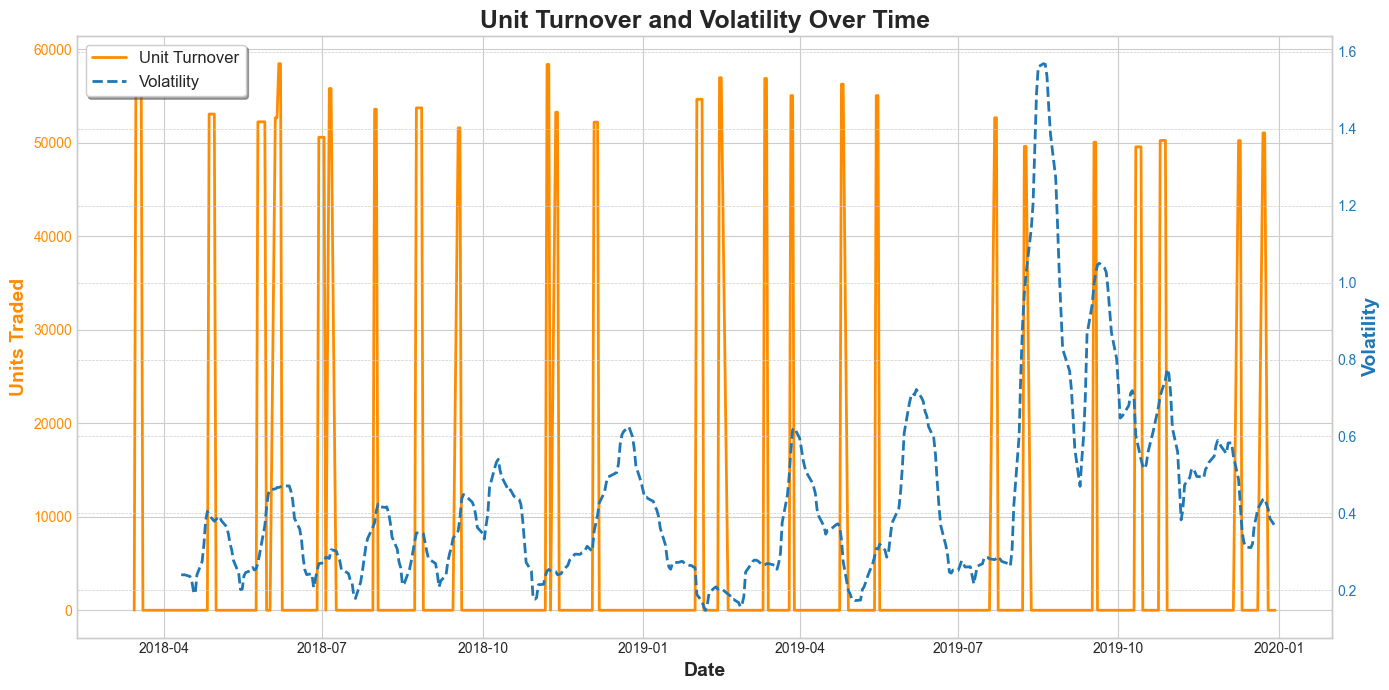

In [60]:
# Calculate the turnover in dollar value traded
sptl_test_data['Dollar_Turnover'] = sptl_test_data['Position'].diff().abs()

# Calculate the total turnover in dollar value traded
total_dollar_turnover = sptl_test_data['Dollar_Turnover'].sum()

# Calculate the turnover in units traded
sptl_test_data['Unit_Turnover'] = ((sptl_test_data['Position'].shift(1) / sptl_test_data['Close'].shift(1)) - (sptl_test_data['Position'] / sptl_test_data['Close'])).abs() 

# Calculate the total turnover in units traded
total_unit_turnover = sptl_test_data['Unit_Turnover'].sum()

print(f'Total Turnover: ${total_dollar_turnover:.2f}')
print(f'Total Unit Turnover: {total_unit_turnover:.2f}')

# Calculate the volatility of the close prices for SPTL
sptl_test_data['Volatility'] = sptl_test_data['Close'].rolling(window=20).std()


# Apply the Seaborn style for consistency and a cleaner look
plt.style.use('seaborn-v0_8-whitegrid')

# Plotting
plt.figure(figsize=(14, 7))

# Primary y-axis for Dollar Turnover
color = 'tab:blue'
plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('Dollar Turnover', fontsize=14, fontweight='bold', color=color)
line1, = plt.plot(sptl_test_data.index, sptl_test_data['Dollar_Turnover'], label='Dollar Turnover', color=color, linewidth=2)
plt.tick_params(axis='y', labelcolor=color)

# Secondary y-axis for Volatility
ax2 = plt.gca().twinx()  # Instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Volatility', fontsize=14, fontweight='bold', color=color)
line2, = ax2.plot(sptl_test_data.index, sptl_test_data['Volatility'], label='Volatility', color=color, linestyle='--', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

# Additional plot adjustments
plt.title('Dollar Turnover and Volatility Over Time', fontsize=18, fontweight='bold')

# Creating a legend that includes both lines
plt.legend([line1, line2], ['Dollar Turnover', 'Volatility'], loc='upper left', fontsize=12, frameon=True, shadow=True)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()  # Adjust the layout to make room for the dual y-axis

# Show plot
plt.show()


# Apply the Seaborn style for consistency
plt.style.use('seaborn-v0_8-whitegrid')

# Plotting
plt.figure(figsize=(14, 7))

# Primary y-axis for Unit Turnover
color = 'darkorange'
plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('Units Traded', fontsize=14, fontweight='bold', color=color)
line1, = plt.plot(sptl_test_data.index, sptl_test_data['Unit_Turnover'], label='Unit Turnover', color=color, linewidth=2)
plt.tick_params(axis='y', labelcolor=color)

# Secondary y-axis for Volatility
ax2 = plt.gca().twinx()
color = 'tab:blue'
ax2.set_ylabel('Volatility', fontsize=14, fontweight='bold', color=color)
line2, = ax2.plot(sptl_test_data.index, sptl_test_data['Volatility'], label='Volatility', color=color, linestyle='--', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

# Additional plot adjustments
plt.title('Unit Turnover and Volatility Over Time', fontsize=18, fontweight='bold')

# Creatin a legend that includes both lines
plt.legend([line1, line2], ['Unit Turnover', 'Volatility'], loc='upper left', fontsize=12, frameon=True, shadow=True)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()  # Adjust the layout to make room for the dual y-axis

# Show plot
plt.show()

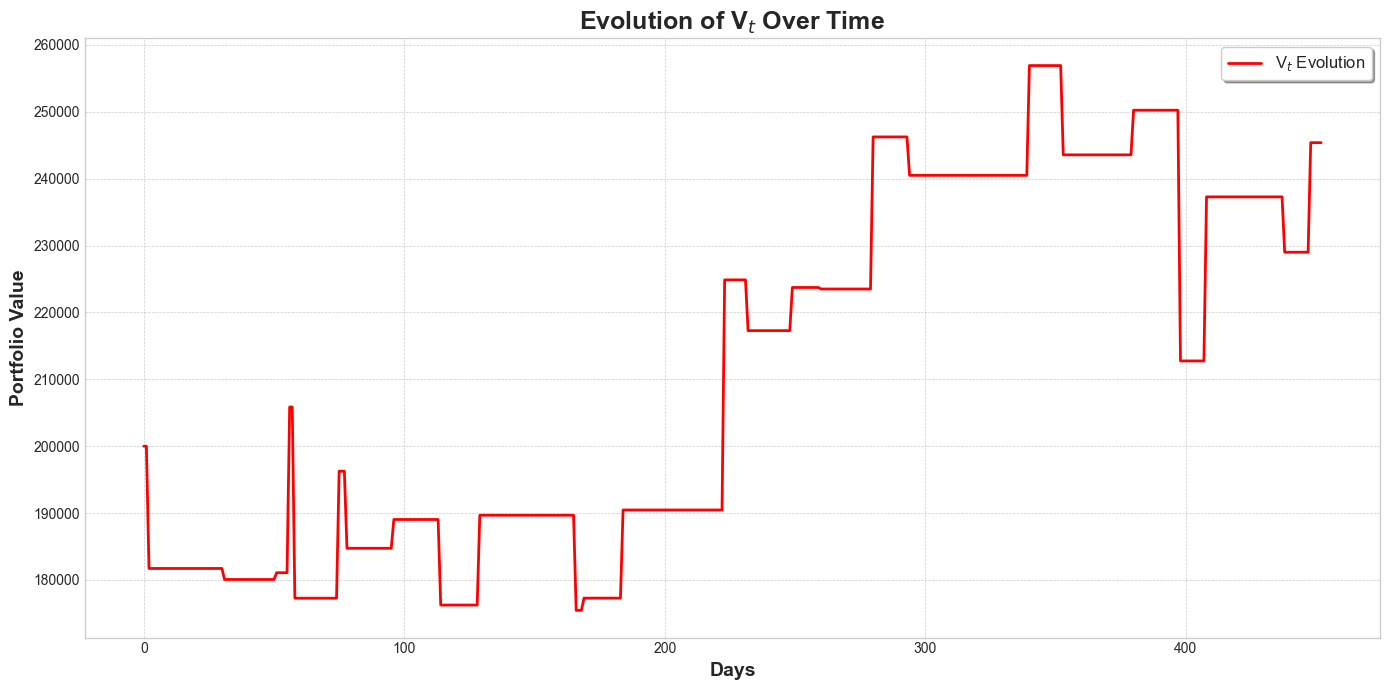

Vt_evolution: [200000.0, 200000.0, 181722.5833776302, 181722.5833776302, 181722.5833776302, 181722.5833776302, 181722.5833776302, 181722.5833776302, 181722.5833776302, 181722.5833776302, 181722.5833776302, 181722.5833776302, 181722.5833776302, 181722.5833776302, 181722.5833776302, 181722.5833776302, 181722.5833776302, 181722.5833776302, 181722.5833776302, 181722.5833776302, 181722.5833776302, 181722.5833776302, 181722.5833776302, 181722.5833776302, 181722.5833776302, 181722.5833776302, 181722.5833776302, 181722.5833776302, 181722.5833776302, 181722.5833776302, 181722.5833776302, 180073.02196514892, 180073.02196514892, 180073.02196514892, 180073.02196514892, 180073.02196514892, 180073.02196514892, 180073.02196514892, 180073.02196514892, 180073.02196514892, 180073.02196514892, 180073.02196514892, 180073.02196514892, 180073.02196514892, 180073.02196514892, 180073.02196514892, 180073.02196514892, 180073.02196514892, 180073.02196514892, 180073.02196514892, 180073.02196514892, 181084.6303721

In [61]:
# Plotting dVt over time
# Apply the Seaborn style for a nicer look
plt.style.use('seaborn-v0_8-whitegrid')

# Plot the evolution of V0 over time
plt.figure(figsize=(14, 7))
plt.plot(Vt_evolution, label='V$_t$ Evolution', color='red', linewidth=2)

# Set titles and labels with adjusted font sizes and weights
plt.title('Evolution of V$_t$ Over Time', fontsize=18, fontweight='bold')
plt.xlabel('Days', fontsize=14, fontweight='bold')
plt.ylabel('Portfolio Value', fontsize=14, fontweight='bold')

# Adjust legend appearance
plt.legend(fontsize=12, frameon=True, shadow=True)

# Ensure the grid is enabled for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust layout for better spacing and save the figure if needed
plt.tight_layout()

# Display the plot
plt.show()

print(f'Vt_evolution: {Vt_evolution}')


Date
2018-03-14       0.000000
2018-03-15    1134.920635
2018-03-16       0.005675
2018-03-19    1031.203549
2018-03-20    1038.414762
                 ...     
2019-12-23      -0.012302
2019-12-24    1230.158730
2019-12-26    1230.158730
2019-12-27    1230.158730
2019-12-30    1230.158730
Name: dVtt, Length: 453, dtype: float64


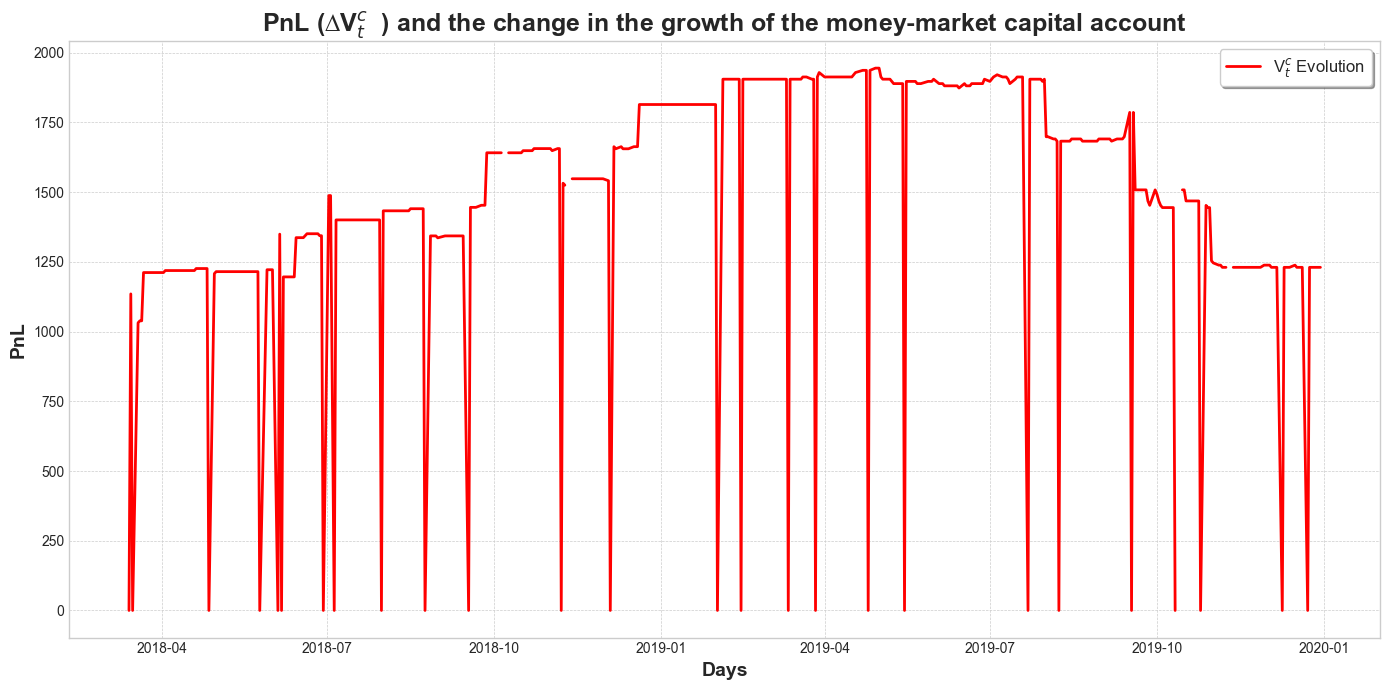

In [62]:
# calculating dVt(cap) over time
sptl_test_data['Mt'] = round((sptl_test_data['Position'].abs()) / L, 0)

sptl_test_data['Extra_Margin'] = sptl_test_data['Vt'] - sptl_test_data['Mt']
#print(sptl_test_data['Extra_Margin'])

sptl_test_data['dVtt'] = sptl_test_data['Extra_Margin'] * effr_data_df['EFFR_Adjusted']
print(sptl_test_data['dVtt'])

# Plotting dVt over time
# Apply the Seaborn style for a nicer look
plt.style.use('seaborn-v0_8-whitegrid')

# Plot the evolution of V0 over time
plt.figure(figsize=(14, 7))
plt.plot(sptl_test_data['dVtt'], label='V$_t^c$ Evolution', color='red', linewidth=2)

# Set titles and labels with adjusted font sizes and weights
plt.title('PnL (∆V$_t^c$  ) and the change in the growth of the money-market capital account', fontsize=18, fontweight='bold')
plt.xlabel('Days', fontsize=14, fontweight='bold')
plt.ylabel('PnL', fontsize=14, fontweight='bold')

# Adjust legend appearance
plt.legend(fontsize=12, frameon=True, shadow=True)

# Ensure the grid is enabled for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust layout for better spacing and save the figure if needed
plt.tight_layout()

# Display the plot
plt.show()

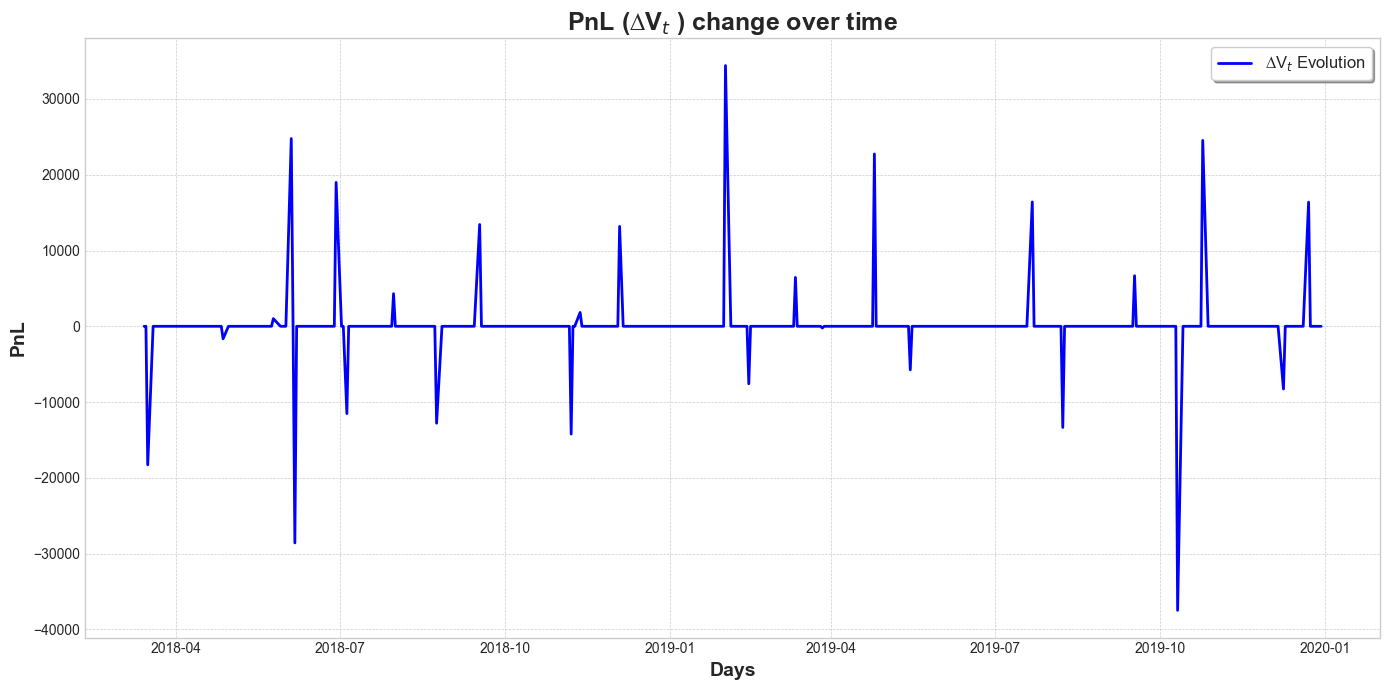

In [63]:
# Plotting dVt over time
# Apply the Seaborn style for a nicer look
plt.style.use('seaborn-v0_8-whitegrid')

# Plot the evolution of V0 over time
plt.figure(figsize=(14, 7))
plt.plot(sptl_test_data['dVt'], label='∆V$_t$ Evolution', color='blue', linewidth=2)

# Set titles and labels with adjusted font sizes and weights
plt.title('PnL (∆V$_t$ ) change over time', fontsize=18, fontweight='bold')
plt.xlabel('Days', fontsize=14, fontweight='bold')
plt.ylabel('PnL', fontsize=14, fontweight='bold')

# Adjust legend appearance
plt.legend(fontsize=12, frameon=True, shadow=True)

# Ensure the grid is enabled for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust layout for better spacing and save the figure if needed
plt.tight_layout()

# Display the plot
plt.show()

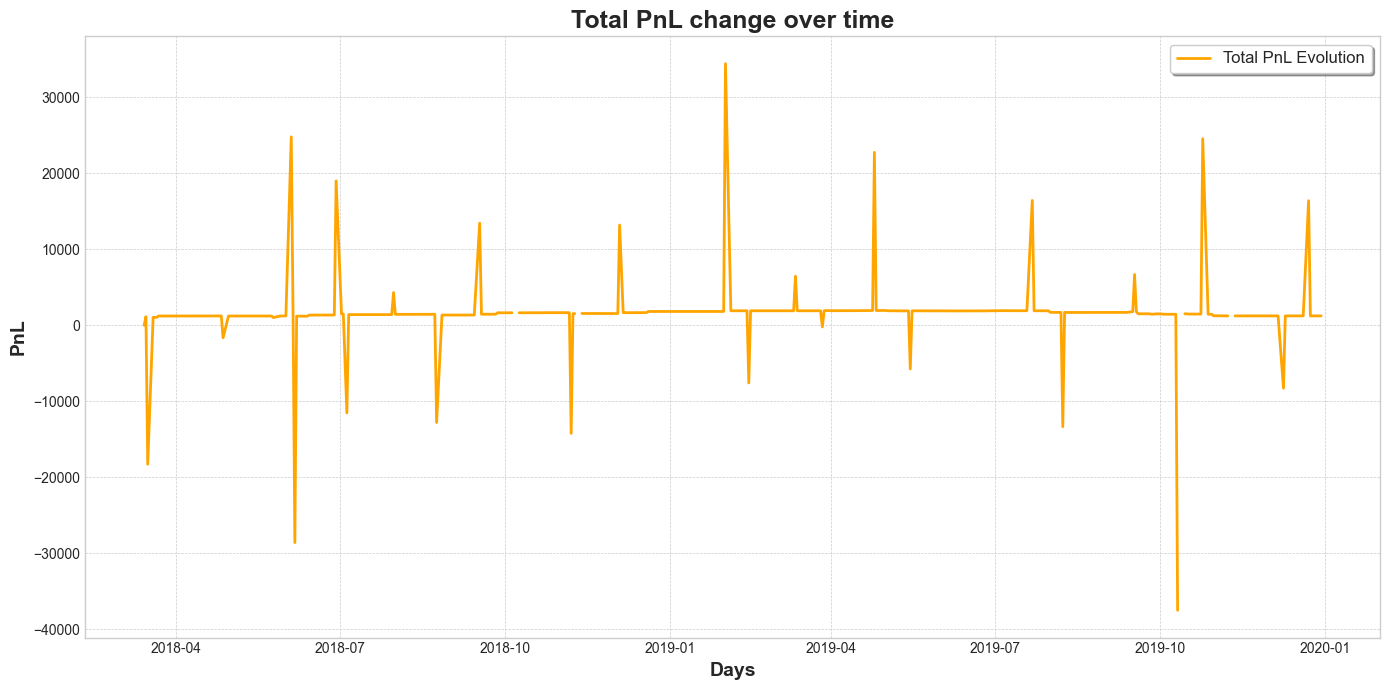

In [64]:
# Total PnL
sptl_test_data['Total_PnL'] = round(sptl_test_data['dVt'] + sptl_test_data['dVtt'],2)
#print(sptl_test_data['Total_PnL'])
#print(sptl_test_data['dVt'])

# Plot the total PnL over time
# Apply the Seaborn style for a nicer look
plt.style.use('seaborn-v0_8-whitegrid')

# Plot the evolution of V0 over time
plt.figure(figsize=(14, 7))
plt.plot(sptl_test_data['Total_PnL'], label='Total PnL Evolution', color='orange', linewidth=2)

# Set titles and labels with adjusted font sizes and weights
plt.title('Total PnL change over time', fontsize=18, fontweight='bold')
plt.xlabel('Days', fontsize=14, fontweight='bold')
plt.ylabel('PnL', fontsize=14, fontweight='bold')

# Adjust legend appearance
plt.legend(fontsize=12, frameon=True, shadow=True)

# Ensure the grid is enabled for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust layout for better spacing and save the figure if needed
plt.tight_layout()

# Display the plot
plt.show()

### 6. Performance Metrics Calculation and Visualization

In [65]:
# TEST DATA METRICS
# Annualization factor
annualization_factor = np.sqrt(252)

# Sharpe Ratio (Annualized)
test_sharpe_ratio_annualized = (sptl_test_data['dVt'].mean() * annualization_factor) / (sptl_test_data['dVt'].std() * annualization_factor)
print(f'Sharpe Ratio (Annualized): {test_sharpe_ratio_annualized:.4f}')
# Sortino Ratio (Annualized)
downside_returns = sptl_test_data['dVt'][sptl_test_data['dVt'] < 0]
downside_std = downside_returns.std()
test_sortino_ratio_annualized = (sptl_test_data['dVt'].mean() * annualization_factor) / downside_std
print(f'Sortino Ratio (Annualized): {test_sortino_ratio_annualized:.4f}')
# Maximum Drawdown (No annualization needed)
cumulative_pnl = sptl_test_data['dVt'].cumsum()
cumulative_max = cumulative_pnl.cummax()
drawdown = cumulative_pnl - cumulative_max
max_drawdown = drawdown.min()
print(f'Maximum Drawdown: {max_drawdown:.2f}')
# Calmar Ratio (Annualized)
calmar_ratio_annualized = (sptl_test_data['dVt'].mean() * annualization_factor) / abs(max_drawdown)
print(f'Calmar Ratio (Annualized): {calmar_ratio_annualized:.4f}')

Sharpe Ratio (Annualized): 0.0243
Sortino Ratio (Annualized): 0.1481
Maximum Drawdown: -44153.88
Calmar Ratio (Annualized): 0.0360


In [66]:
# Initial capital
V0 = 200000.00

# Leverage
L = 10

# Maximum dollar value of SPTL that can be held, given the leverage
max_dollar_value = V0 * L

# Position storage
positions = [0]
dVt = []
max_value = [0]

# Reindex the EFFR data to align with sptl_data
sptl_data['EFFR_Adjusted'] = effr_data_df['EFFR_Adjusted'].reindex(sptl_data.index).fillna(method='ffill')

# Separate the training and test data
sptl_train_data = sptl_data.iloc[:train_size].copy()

# Initialize a list to store the evolution of V0 over time
Vt_evolution = [V0]

# Calculate the daily returns for SPTL
sptl_train_data['Pct_Change'] = sptl_train_data['Close'].pct_change()
pnl = 0

# Simulate the trading strategy on the test data
for index, row in sptl_train_data.iterrows():
    # Calculate the position based on the signal
    # Handle the first iteration where there is no previous signal
    if index == sptl_train_data.index[0]:
        position = 0  # No position on the first day
    else:
        previous_signal = sptl_train_data.loc[sptl_train_data.index < index, 'Signals'].iloc[-1]
        max_value.append(max_dollar_value / L)
        position = previous_signal * (round((max_dollar_value / row['Close']), 0) * row['Close'])
        positions.append(position)  # Store the position for the row
    
    
    # Calculate PnL for the row
        pnl = (row['Pct_Change'] - row['EFFR_Adjusted']) * position
        V0 += pnl  # Update V0 with the PnL
        Vt_evolution.append(V0)  # Append the new V0 to the evolution list
    # Update the maximum dollar value based on the new V0
    max_dollar_value = min(200000 * L, V0 * L)

    dVt.append(pnl) # Store the PnL for the row
sptl_train_data['Position'] = positions  # Store the positions in the DataFrame
sptl_train_data['Vt'] = max_value
sptl_train_data['dVt'] = dVt
# Print the evolution of V0 over time
for i, value in enumerate(Vt_evolution):
    print(f"Day {i}: V0 = {value:.2f}")

print(positions)

Day 0: V0 = 200000.00
Day 1: V0 = 200000.00
Day 2: V0 = 200000.00
Day 3: V0 = 200000.00
Day 4: V0 = 200000.00
Day 5: V0 = 200000.00
Day 6: V0 = 200000.00
Day 7: V0 = 200000.00
Day 8: V0 = 200000.00
Day 9: V0 = 200000.00
Day 10: V0 = 200000.00
Day 11: V0 = 200000.00
Day 12: V0 = 200000.00
Day 13: V0 = 200000.00
Day 14: V0 = 200000.00
Day 15: V0 = 200000.00
Day 16: V0 = 200000.00
Day 17: V0 = 200000.00
Day 18: V0 = 200000.00
Day 19: V0 = 200000.00
Day 20: V0 = 200000.00
Day 21: V0 = 216473.78
Day 22: V0 = 216473.78
Day 23: V0 = 216473.78
Day 24: V0 = 216473.78
Day 25: V0 = 216473.78
Day 26: V0 = 216473.78
Day 27: V0 = 216473.78
Day 28: V0 = 216473.78
Day 29: V0 = 216473.78
Day 30: V0 = 216473.78
Day 31: V0 = 216473.78
Day 32: V0 = 216473.78
Day 33: V0 = 216473.78
Day 34: V0 = 216473.78
Day 35: V0 = 216473.78
Day 36: V0 = 216473.78
Day 37: V0 = 216473.78
Day 38: V0 = 216473.78
Day 39: V0 = 216473.78
Day 40: V0 = 208533.47
Day 41: V0 = 208533.47
Day 42: V0 = 208533.47
Day 43: V0 = 208533.4

/var/folders/tv/bjxgwfxn7578_3m4cl8608dm0000gn/T/ipykernel_26634/1477068933.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sptl_data['EFFR_Adjusted'] = effr_data_df['EFFR_Adjusted'].reindex(sptl_data.index).fillna(method='ffill')


In [67]:
# TRAIN DATA METRICS
annualization_factor = np.sqrt(252)

# Sharpe Ratio (Annualized)
test_sharpe_ratio_annualized = (sptl_train_data['dVt'].mean() * annualization_factor) / (sptl_train_data['dVt'].std() * annualization_factor)
print(f'Sharpe Ratio (Annualized): {test_sharpe_ratio_annualized:.4f}')
# Sortino Ratio (Annualized)
downside_returns = sptl_train_data['dVt'][sptl_train_data['dVt'] < 0]
downside_std = downside_returns.std()
test_sortino_ratio_annualized = (sptl_train_data['dVt'].mean() * annualization_factor) / downside_std
print(f'Sortino Ratio (Annualized): {test_sortino_ratio_annualized:.4f}')
# Maximum Drawdown (No annualization needed)
cumulative_pnl = sptl_train_data['dVt'].cumsum()
cumulative_max = cumulative_pnl.cummax()
drawdown = cumulative_pnl - cumulative_max
max_drawdown = drawdown.min()
print(f'Maximum Drawdown: {max_drawdown:.2f}')
# Calmar Ratio (Annualized)
calmar_ratio_annualized = (sptl_train_data['dVt'].mean() * annualization_factor) / abs(max_drawdown)
print(f'Calmar Ratio (Annualized): {calmar_ratio_annualized:.4f}')

Sharpe Ratio (Annualized): 0.0132
Sortino Ratio (Annualized): 0.0849
Maximum Drawdown: -100160.77
Calmar Ratio (Annualized): 0.0077


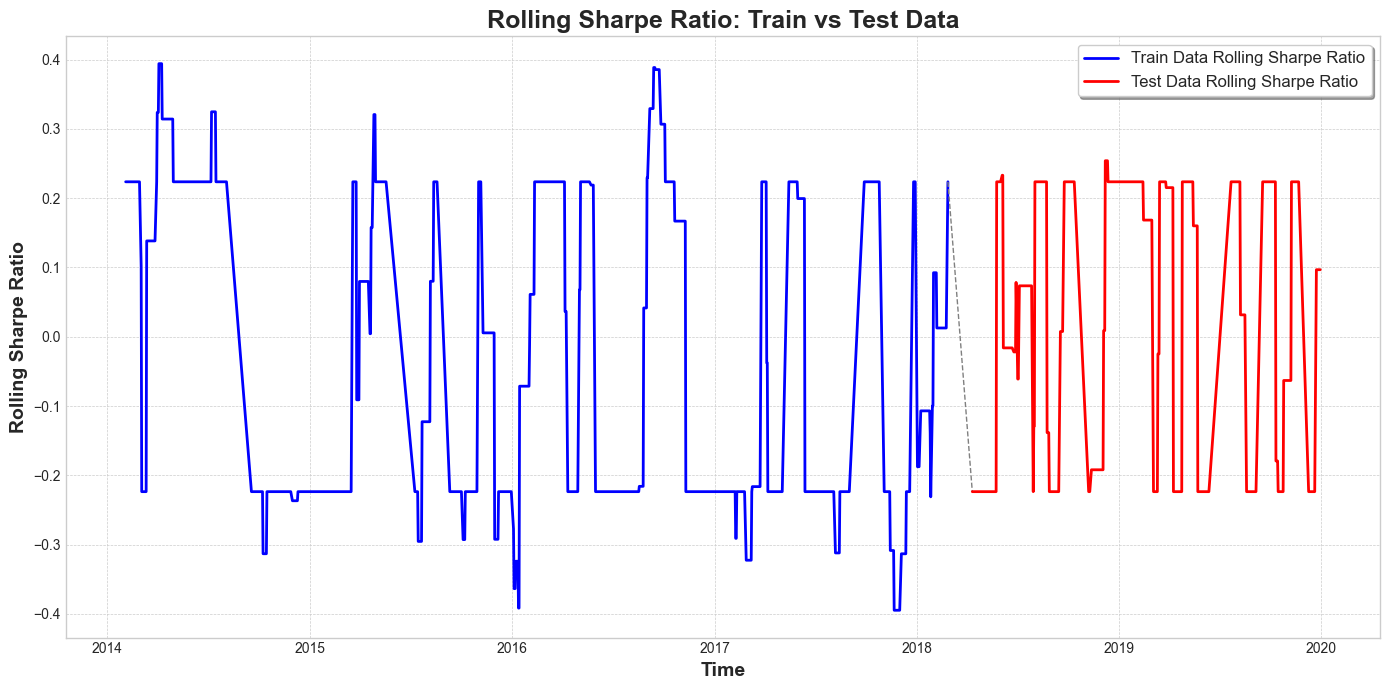

In [72]:
# Drop NaN values that could be the result of rolling calculation
rolling_sharpe_ratio_train = rolling_sharpe_ratio_train.dropna()
rolling_sharpe_ratio_test = rolling_sharpe_ratio_test.dropna()

# Apply the Seaborn style for a nicer look
plt.style.use('seaborn-v0_8-whitegrid')

# Plot the Rolling Sharpe Ratio for Train Data
plt.figure(figsize=(14, 7))
plt.plot(rolling_sharpe_ratio_train.index, rolling_sharpe_ratio_train, label='Train Data Rolling Sharpe Ratio', color='blue', linewidth=2)

# Plot the Rolling Sharpe Ratio for Test Data, connecting to the last point of Train Data
# Find the last date of the training dataset and its Sharpe ratio
last_train_date = rolling_sharpe_ratio_train.dropna().index[-1]
last_train_sharpe = rolling_sharpe_ratio_train.dropna().iloc[-1]

# Find the first date of the testing dataset and its Sharpe ratio
first_test_date = rolling_sharpe_ratio_test.dropna().index[0]
first_test_sharpe = rolling_sharpe_ratio_test.dropna().iloc[0]

# If there's a gap, fill it by plotting a line between the last point of the training set
# and the first point of the testing set
if first_test_date != last_train_date:
    plt.plot([last_train_date, first_test_date], [last_train_sharpe, first_test_sharpe], color='grey', linestyle='--', linewidth=1)

# Continue plotting the test set from the first point
plt.plot(rolling_sharpe_ratio_test.index, rolling_sharpe_ratio_test, label='Test Data Rolling Sharpe Ratio', color='red', linewidth=2)

# Set titles and labels with adjusted font sizes and weights
plt.title('Rolling Sharpe Ratio: Train vs Test Data', fontsize=18, fontweight='bold')
plt.xlabel('Time', fontsize=14, fontweight='bold')
plt.ylabel('Rolling Sharpe Ratio', fontsize=14, fontweight='bold')

# Adjust legend appearance
plt.legend(fontsize=12, frameon=True, shadow=True)

# Ensure the grid is enabled for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust layout for better spacing and save the figure if needed
plt.tight_layout()

# Display the plot
plt.show()


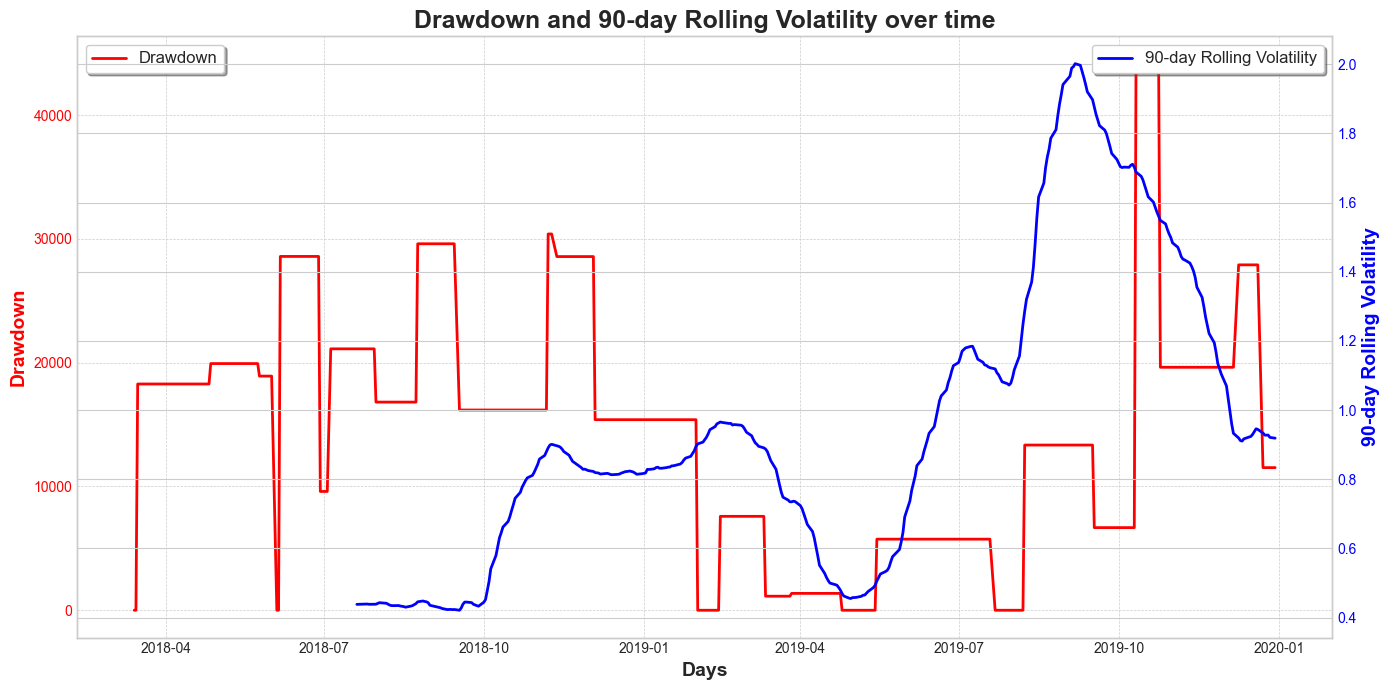

In [73]:
# Calculate the drawdown over time and the historic rolling 90-day volatility of the underlying asset for the test set
# Calculate the cumulative PnL
sptl_test_data['Cumulative_PnL'] = sptl_test_data['dVt'].cumsum()

# Calculate the rolling maximum of the cumulative PnL to represent the peak
sptl_test_data['Rolling_Max_PnL'] = sptl_test_data['Cumulative_PnL'].cummax()

# Calculate the Drawdown
sptl_test_data['Drawdown'] = sptl_test_data['Rolling_Max_PnL'] - sptl_test_data['Cumulative_PnL']



# Calculate the historic rolling 90-day volatility of the closing prices
sptl_test_data['Volatility'] = sptl_test_data['Close'].rolling(window=90).std()

# Apply the Seaborn style for a nicer look
plt.style.use('seaborn-v0_8-whitegrid')

# Create the figure and the first axis for the Drawdown
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot the Drawdown on the first axis
ax1.plot(sptl_test_data.index, sptl_test_data['Drawdown'], label='Drawdown', color='red', linewidth=2)
ax1.set_xlabel('Days', fontsize=14, fontweight='bold')
ax1.set_ylabel('Drawdown', color='red', fontsize=14, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='red')
ax1.legend(loc='upper left', fontsize=12, frameon=True, shadow=True)

# Create a second axis for the volatility shared x-axis with the first axis
ax2 = ax1.twinx()
ax2.plot(sptl_test_data.index, sptl_test_data['Volatility'], label='90-day Rolling Volatility', color='blue', linewidth=2)
ax2.set_ylabel('90-day Rolling Volatility', color='blue', fontsize=14, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.legend(loc='upper right', fontsize=12, frameon=True, shadow=True)

# Set title and grid
plt.title('Drawdown and 90-day Rolling Volatility over time', fontsize=18, fontweight='bold')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust layout for better spacing
fig.tight_layout()

# Display the plot
plt.show()